In [ ]:
!pip install packaging==21.3
!pip install pycaret[full] scikit-learn

In [1]:
import os
from os.path import join, dirname
import random
import warnings

import numpy as np
import pandas as pd
import spacy
from tqdm import tqdm, trange

from pycaret.classification import setup, compare_models, create_model, tune_model, blend_models, evaluate_model, automl, predict_model

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

nlp = spacy.load("en_core_web_sm")

In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)  # type: ignore
#     torch.backends.cudnn.deterministic = True  # type: ignore
#     torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

In [3]:
class PATH:
    root   = '/root/court-decision-prediction'
    yaml   = join(root, 'court_decision_prediction/configs.yaml')
    data   = join(root, 'data/open')
    train  = join(data, 'train.csv')
    test   = join(data, 'test.csv')
    sample = join(data, 'sample_submission.csv')
    submit = join(root, 'submission')
    models = join(root, 'models')

# 1. Load Data 

In [4]:
train_full_data = pd.read_csv(PATH.train)
test_data       = pd.read_csv(PATH.test)
target          = 'first_party_winner'

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


def preprocess(data, target):
#     data = select_facts(data)
    data = append_party_group(data)
    if target in data:
#         data = undersampling(data, target)'
#         data = oversampling(data, target)
        cols = ['first_party_grp', 'second_party_grp', target]
    else:
        cols = ['first_party_grp', 'second_party_grp']
    return data[cols]


# def select_facts(data):
#     transition_words = ["accordingly", "additionally", "also", "although", "alternatively", "as a result", "besides", "but", "consequently", "conversely", "despite", "due to", "either", "equally", "eventually", "finally", "first", "furthermore", "hence", "however", "in addition", "in conclusion", "in contrast", "in other words", "in spite of", "instead", "likewise", "meanwhile", "moreover", "nevertheless", "next", "nonetheless", "nor", "on the contrary", "on the other hand", "otherwise", "overall", "particularly", "similarly", "since", "so", "subsequently", "that is", "then", "therefore", "though", "thus", "ultimately", "unless", "unlike", "until", "when", "whereas", "while", "yet", "above all", "afterward", "all in all", "as an illustration", "as well as", "at the same time", "at length", "basically", "certainly", "comparatively", "consequently", "eventually", "for example", "for instance", "for this reason", "for the most part", "for this purpose", "generally", "given these points", "in a word", "in any case", "in essence", "in fact", "in general", "in particular", "in reality", "in short", "in summary", "in the first place", "notably", "of course", "of great importance", "of necessity", "of course", "of great importance", "of necessity", "specifically", "surprisingly", "to begin with", "to conclude", "to illustrate", "to sum up", "to summarize", "truly", "without a doubt"]
#     core_words       = ['court', 'reverse', 'judge', 'adjudicate', 'guilty']

#     data = data.reset_index(drop=True)
#     docs = data.facts

#     for doc_id, doc in enumerate(tqdm(docs)):
#         selected_sents = []
#         for sent in nlp(doc).sents:
#             sent_str = sent.text
#             cond1 = any(sent_str.lower().startswith(word) for word in transition_words)
#             cond2 = any(word in sent.lemma_.lower() for word in core_words)
#             is_selected = True if any([cond1, cond2]) else False
#             if is_selected:
#                 selected_sents.append(sent_str)
#         data.loc[doc_id, 'facts'] = '\n'.join(selected_sents)
#     return data


def append_party_group(data):
    data = data.copy()

    def generate_fn(col):
        len_filter = lambda fn, arr: len(list(filter(fn, arr)))  # get number of elements in arr filtered by fn

        def fn(row):
            party       = row[col]
            party_lower = row[col].lower()

            keywords_usa = ['united states', 'federal', 'commision', 'commodity', 'national']
            keywords_gpe = ['school board', 'city', 'republic', 'region', 'district', 'county']
            keywords_org = ['corporation', 'inc', 'company', 'bank', 'association', 'llc', 'ltd', 'llp', 'co.', 'hospital', 'usa', 'school', 'group', 'office', 'department']
            keywords_grp = [',', 'et al']

            for keyword in keywords_usa:
                if keyword in party_lower:
                    return 'USA'
            else:
                ents = nlp(party).ents
                labels = [e.label_ for e in ents]
                if ('GPE' in labels) or len_filter(lambda k: k in party_lower, keywords_gpe):
                    return 'GPE'
                elif ('ORG' in labels) or ('NORP' in labels) or len_filter(lambda k: k in party_lower, keywords_org):
                    return 'ORG'
                elif (len(labels) > 1) or len_filter(lambda k: k in party_lower, keywords_grp):
                    return 'GRP'
                else:
                    return 'IND'

        return fn

    data['first_party_grp']  = data.apply(generate_fn('first_party'), axis=1)
    data['second_party_grp'] = data.apply(generate_fn('second_party'), axis=1)
    return data

def undersampling(data, target):
    data_zero_target = data[data[target] == 0]
    data_one_target  = data[data[target] == 1]
    first_party_grp_int = LabelEncoder().fit_transform(data_one_target['first_party_grp'])
    data_one_target_sample = resample(data_one_target, replace=False, n_samples=len(data_zero_target), stratify=first_party_grp_int)
    data = pd.concat([data_zero_target, data_one_target_sample], ignore_index=True)
    return data.sample(frac=1).reset_index(drop=True)

def oversampling(data, target):
    data_zero_target = data[data[target] == 0]
    data_one_target  = data[data[target] == 1]
    first_party_grp_int = LabelEncoder().fit_transform(data_zero_target['first_party_grp'])
    data_zero_target_sample = resample(data_zero_target, replace=True, n_samples=len(data_one_target) - len(data_zero_target), stratify=first_party_grp_int)
    data = pd.concat([data_zero_target, data_zero_target_sample, data_one_target], ignore_index=True)
    return data.sample(frac=1).reset_index(drop=True)

In [6]:
train_full_data_pp = preprocess(train_full_data, target)
test_data_pp       = preprocess(test_data, target)

In [7]:
train_full_data_pp[target].value_counts()

1    1649
0     829
Name: first_party_winner, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

ones         = train_full_data_pp[train_full_data_pp[target] == 1]
zeros        = train_full_data_pp[train_full_data_pp[target] == 0]
first_party_grp_int = LabelEncoder().fit_transform(ones['first_party_grp'])
ones1, ones2 = train_test_split(ones, test_size=829, stratify=first_party_grp_int)

train_val_data = pd.concat([ones2, zeros])
train_val_data[target].value_counts()

1    829
0    829
Name: first_party_winner, dtype: int64

In [18]:
len(ones), len(ones1), len(ones2)

(1649, 820, 829)

In [21]:
train_data1, val_data = train_test_split(train_val_data, test_size=0.3, stratify=train_val_data[target])
len(train_data1), len(val_data)

(1160, 498)

In [22]:
train_data = pd.concat([ones1, train_data1])

In [23]:
len(train_data), len(val_data)

(1980, 498)

In [25]:
val_data[target].value_counts()

0    249
1    249
Name: first_party_winner, dtype: int64

In [28]:
train_data = oversampling(train_data, target)
train_data[target].value_counts()

0    1400
1    1400
Name: first_party_winner, dtype: int64

In [30]:
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

1649 -> (249) + (580 + 820) \
829  -> (249) + (580 + **820**)

In [ ]:
def plot_conf_heatmap(data):
    conf = data.pivot_table(index='first_party_grp', columns='second_party_grp', values='first_party_winner')
    sns.heatmap(conf, annot=True, center=data[target].mean(), cmap='coolwarm')
    plt.show()

In [ ]:
d = train_full_data_pp
zeros = d[d[target] == 0] #.drop(columns=target)
ones  = d[d[target] == 1] #.drop(columns=target)

In [ ]:
plot_conf_heatmap(d)

In [ ]:
combined_counts

In [ ]:
cnts

In [ ]:
zd = zeros.drop(columns=target)
od = ones.drop(columns=target)

fig, axes = plt.subplots(ncols=5, figsize=(30, 3))
unique_grps = d.first_party_grp.unique()
for ax, first_party_grp in zip(axes.flat, unique_grps):
    ax.set_title(f"first={first_party_grp}")
    zero_cnts = zd[zd.first_party_grp == first_party_grp].second_party_grp.value_counts() / len(zd[zd.first_party_grp == first_party_grp])
    one_cnts  = od[od.first_party_grp == first_party_grp].second_party_grp.value_counts() / len(od[od.first_party_grp == first_party_grp])
    cnts      = pd.concat([zero_cnts, one_cnts], axis=1)

    cnts = cnts.reindex(unique_grps)
    cnts.columns = ['target=0', 'target=1']
    
    cnts['(y=1) - (y=0)'] = cnts['target=1'] - cnts['target=0']
    cnts[['(y=1) - (y=0)']].plot.bar(ax=ax)
    ax.axhline(0, color='k')
plt.show()

In [ ]:
zp = zeros.pivot_table(index='first_party_grp', columns='second_party_grp', aggfunc='count') / len(zeros) * 100
zp.round(2).style.background_gradient(axis=1)

In [ ]:
op = ones.pivot_table(index='first_party_grp', columns='second_party_grp', aggfunc='count') / len(ones) * 100
op.round(2).style.background_gradient(axis=1)

# 2. Modeling

In [34]:
s = setup(train_data, test_data=val_data, target=target, categorical_features=['first_party_grp', 'second_party_grp'], use_gpu=True, index=False)

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

,Description,Value
0,Session id,4656
1,Target,first_party_winner
2,Target type,Binary
3,Original data shape,"(3298, 3)"
4,Transformed data shape,"(3298, 11)"
5,Transformed train set shape,"(2800, 11)"
6,Transformed test set shape,"(498, 11)"
7,Categorical features,2
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [35]:
base_models = compare_models(n_select=5, sort='MCC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.5386,0.0000,0.6829,0.5353,0.5801,0.0771,0.0912,0.0630
knn,K Neighbors Classifier,0.5407,0.5401,0.6571,0.5354,0.5860,0.0814,0.0845,0.1270
rf,Random Forest Classifier,0.5389,0.5657,0.5371,0.5400,0.5375,0.0779,0.0781,0.4730
xgboost,Extreme Gradient Boosting,0.5354,0.5646,0.5414,0.5357,0.5363,0.0707,0.0712,0.2510
ridge,Ridge Classifier,0.5321,0.0000,0.7036,0.5233,0.5994,0.0643,0.0700,0.0950
lda,Linear Discriminant Analysis,0.5321,0.5617,0.7036,0.5233,0.5994,0.0643,0.0700,0.0770
ada,Ada Boost Classifier,0.5314,0.5616,0.6979,0.5228,0.5966,0.0629,0.0685,0.1490
gbc,Gradient Boosting Classifier,0.5332,0.5660,0.5457,0.5321,0.5362,0.0664,0.0670,0.1720
dt,Decision Tree Classifier,0.5329,0.5646,0.5186,0.5347,0.5252,0.0657,0.0659,0.0750
et,Extra Trees Classifier,0.5329,0.5646,0.5186,0.5347,0.5252,0.0657,0.0659,0.4130


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

In [37]:
base_model = base_models[3]

In [ ]:
base_models = [
    create_model('svm'),
    create_model('xgboost'),
    create_model('gbc'),
    create_model('catboost')
]

In [38]:
final_model = base_model

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

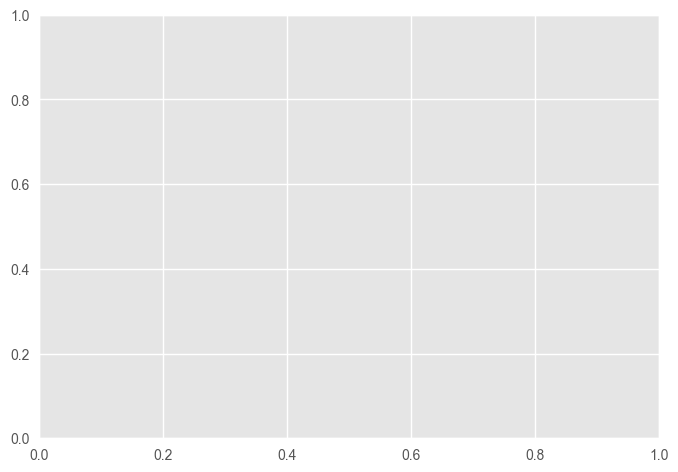

In [39]:
# 4) Hyperparameter tuning
# tuned_models = [tune_model(model, choose_better=True, return_train_score=True, optimize='MCC') for model in base_models]

# 5) Ensemble models
# ensemble_model = blend_models(tuned_models, choose_better=True, return_train_score=True)  # voting(average)
# final_model = blend_models(base_models, choose_better=True, return_train_score=True, optimize='MCC')  # voting(average)

# 6) Select final model
# final_model = automl(return_train_score=True)  # 생성한 모델들 중 최적의 모델을 선택
# final_model = base_models[0]

# 7) Evaluate model
evaluate_model(final_model)  # 다양한 평가지표들과 시각자료들을 통해 모델을 평가

# 8) Predict
preds = predict_model(final_model, data=test_data_pp)  # 'Label' column으로 예측값을 추가

```
        Accuracy	AUC	Recall	Prec.	F1	Kappa	MCC
Split	Fold	 	 	 	 	 	 	 
CV-Train	0	0.5642	0.0000	0.7261	0.5485	0.6249	0.1284	0.1357
1	0.5757	0.0000	0.6322	0.5680	0.5984	0.1513	0.1523
2	0.5699	0.0000	0.7605	0.5506	0.6388	0.1398	0.1513
3	0.5776	0.0000	0.6073	0.5732	0.5898	0.1552	0.1554
4	0.5575	0.0000	0.7816	0.5397	0.6385	0.1149	0.1286
5	0.5699	0.0000	0.7548	0.5510	0.6370	0.1398	0.1505
6	0.5718	0.0000	0.6935	0.5578	0.6183	0.1437	0.1481
7	0.5670	0.0000	0.7701	0.5477	0.6401	0.1341	0.1467
8	0.5718	0.0000	0.6456	0.5626	0.6012	0.1437	0.1453
9	0.5623	0.0000	0.7835	0.5432	0.6416	0.1245	0.1389
CV-Val	0	0.5603	0.0000	0.7586	0.5432	0.6331	0.1207	0.1315
1	0.4914	0.0000	0.5345	0.4921	0.5124	-0.0172	-0.0173
2	0.5259	0.0000	0.7759	0.5172	0.6207	0.0517	0.0597
3	0.4655	0.0000	0.4655	0.4655	0.4655	-0.0690	-0.0690
4	0.6121	0.0000	0.8793	0.5730	0.6939	0.2241	0.2652
5	0.5690	0.0000	0.7414	0.5513	0.6324	0.1379	0.1469
6	0.4828	0.0000	0.5862	0.4857	0.5312	-0.0345	-0.0352
7	0.5690	0.0000	0.7414	0.5513	0.6324	0.1379	0.1469
8	0.5603	0.0000	0.6724	0.5493	0.6047	0.1207	0.1238
9	0.5517	0.0000	0.7931	0.5349	0.6389	0.1034	0.1181
CV-Train	Mean	0.5688	0.0000	0.7155	0.5542	0.6229	0.1375	0.1453
Std	0.0058	0.0000	0.0630	0.0103	0.0188	0.0117	0.0080
CV-Val	Mean	0.5388	0.0000	0.6948	0.5264	0.5965	0.0776	0.0871
Std	0.0438	0.0000	0.1222	0.0330	0.0666	0.0877	0.0970
Train	nan	0.5621	0.5621	0.6793	0.5503	0.6080	0.1241	0.1277
```

In [40]:
preds

,first_party_grp,second_party_grp,prediction_label,prediction_score
0,IND,USA,0,0.6601
1,ORG,ORG,0,0.5338
2,USA,ORG,1,0.6415
3,IND,USA,0,0.6601
4,IND,IND,1,0.5195
...,...,...,...,...
1235,ORG,ORG,0,0.5338
1236,IND,ORG,1,0.5254
1237,GRP,IND,1,0.5312
1238,ORG,IND,0,0.5172


In [41]:
preds_val = predict_model(final_model, data=val_data)  # 'Label' column으로 예측값을 추가

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5100,0.5209,0.5663,0.5090,0.5361,0.0201,0.0202


In [52]:
preds_val.head(10)

,first_party_grp,second_party_grp,first_party_winner,prediction_label,prediction_score
0,ORG,IND,0,0,0.5172
1,IND,ORG,0,1,0.5254
2,IND,IND,1,1,0.5195
3,IND,IND,1,1,0.5195
4,ORG,GRP,0,1,0.6539
5,IND,USA,0,0,0.6601
6,GPE,IND,1,1,0.6089
7,GRP,GRP,0,1,0.5849
8,ORG,GPE,1,1,0.5999
9,IND,USA,1,0,0.6601


In [56]:
preds_val['prediction_score']

0.6666

In [53]:
zeros = preds_val[preds_val[target] == 0]
ones  = preds_val[preds_val[target] == 1]

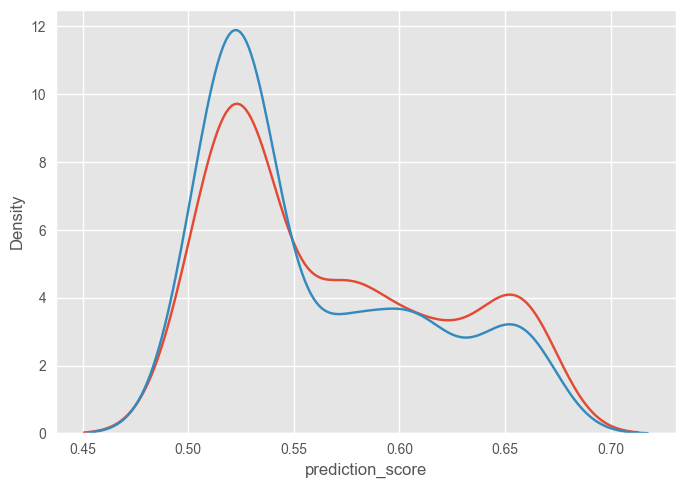

In [54]:
sns.kdeplot(zeros['prediction_score'])
sns.kdeplot(ones['prediction_score']);

In [59]:
submit = pd.read_csv(PATH.sample)
submit[target] = preds['prediction_label']
submit.to_csv(join(PATH.submit, f"xgboost-oversampling-advanced_data.csv"), index=False)